In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os 
path_data = os.path.join("..","data", "city_day.csv")
df = pd.read_csv(path_data)


In [6]:
print("Dataset Shape:", df.shape)

Dataset Shape: (27284, 15)


In [ ]:
print("\nColumns:", df.columns.tolist())



Columns: ['City', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']

Missing values per column:


In [8]:
print("\nMissing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")


Missing values per column:
City              0
PM2.5          2351
PM10           8894
NO             1336
NO2            1339
NOx            2150
NH3            8082
CO              576
SO2            1608
O3             1776
Benzene        4098
Toluene        6514
Xylene        16549
AQI            2450
AQI_Bucket     2450
dtype: int64

Total missing values: 60173


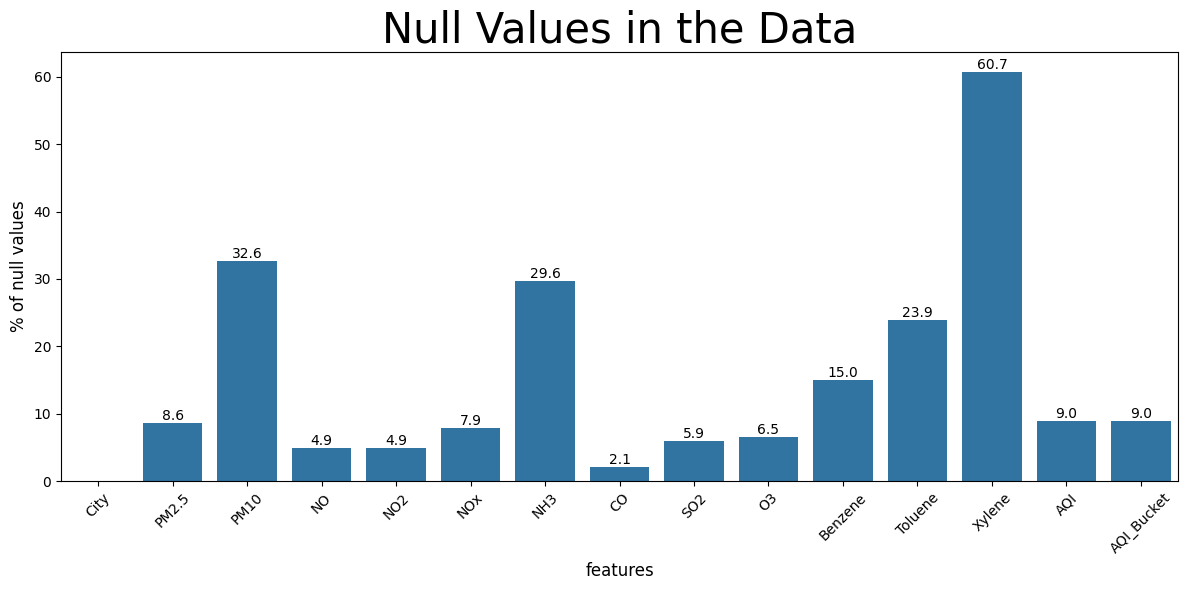

In [ ]:
data_nulls = (df.apply(lambda x: x.isnull().value_counts()).T[True]/len(df)*100).reset_index(name='count')
fig = plt.figure(figsize=(12,6))
fig = sns.barplot(data_nulls, x="index", y="count")
fig.set_title('Null Values in the Data', fontsize=30)
fig.set_xlabel('features', fontsize=12)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.set_ylabel('% of null values', fontsize=12)
fig.bar_label(fig.containers[0], fmt='%.1f')
plt.tight_layout()

In [9]:
print("\nAQI_Bucket value counts:")
print(df['AQI_Bucket'].value_counts())
aqi_order = df['AQI_Bucket'].unique().tolist()
aqi_order


AQI_Bucket value counts:
AQI_Bucket
Moderate        8824
Satisfactory    8218
Poor            2780
Very Poor       2337
Good            1338
Severe          1337
Name: count, dtype: int64


[nan, 'Poor', 'Very Poor', 'Severe', 'Moderate', 'Satisfactory', 'Good']

In [11]:
df = df[df['AQI_Bucket'].notna()]
aqi_order = df['AQI_Bucket'].unique().tolist()
aqi_order

['Poor', 'Very Poor', 'Severe', 'Moderate', 'Satisfactory', 'Good']

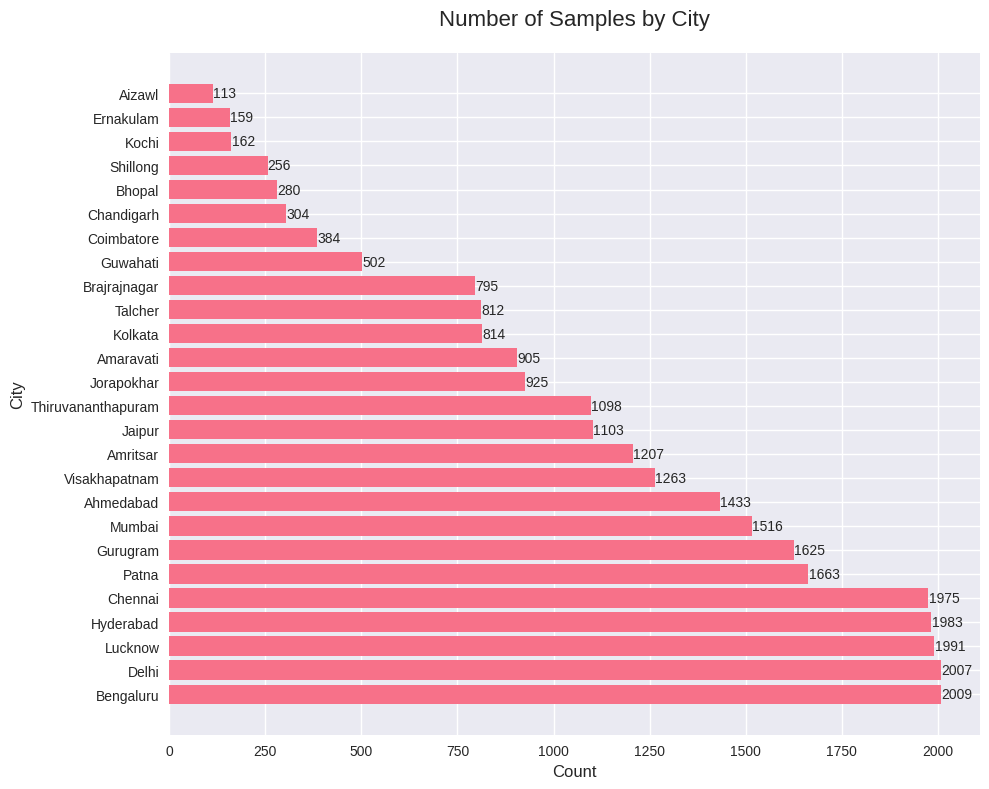

In [ ]:
city_counts = df['City'].value_counts()
plt.figure(figsize=(10, 8))
bars = plt.barh(city_counts.index, city_counts.values)
plt.title('Number of Samples by City', fontsize=16, pad=20)
plt.xlabel('Count', fontsize=12)
plt.ylabel('City', fontsize=12)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
             f'{int(width)}', ha='left', va='center')

plt.tight_layout()
plt.show()

Class Distribution Statistics:
Total samples: 27284
Number of classes: 6
Most common class: Moderate (8824 samples)
Least common class: Severe (1337 samples)
Imbalance ratio: 6.60


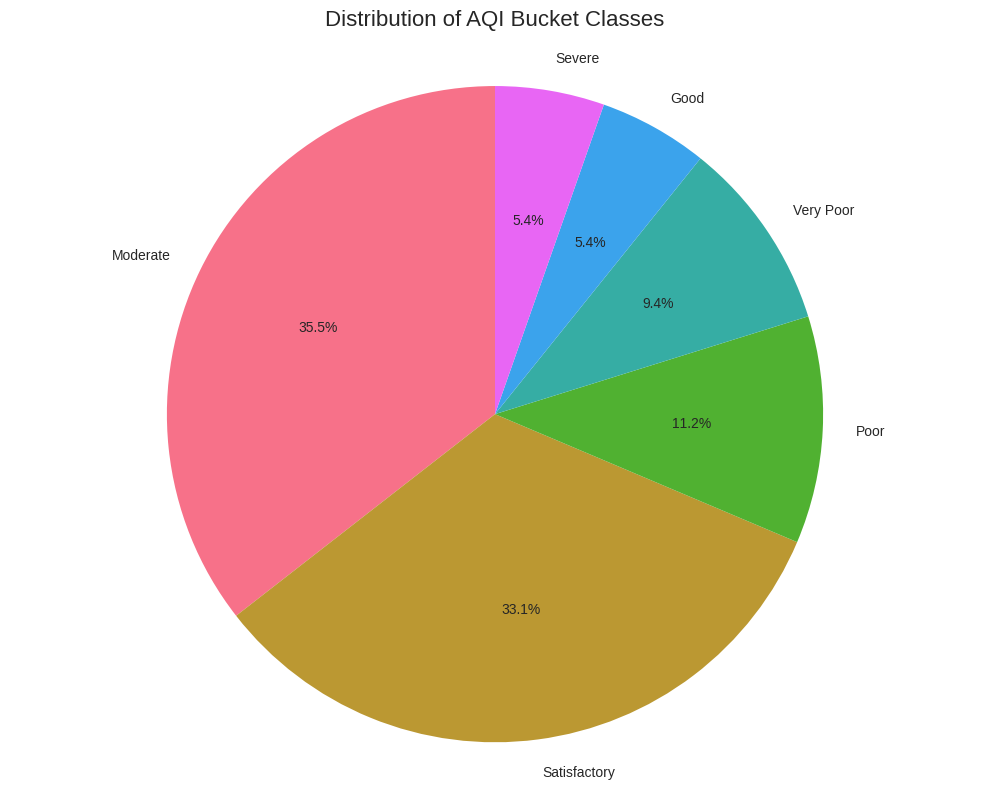

In [ ]:
class_dist = df['AQI_Bucket'].value_counts()

print("Class Distribution Statistics:")
print(f"Total samples: {len(df)}")
print(f"Number of classes: {len(class_dist)}")
print(f"Most common class: {class_dist.index[0]} ({class_dist.values[0]} samples)")
print(f"Least common class: {class_dist.index[-1]} ({class_dist.values[-1]} samples)")
print(f"Imbalance ratio: {class_dist.values[0]/class_dist.values[-1]:.2f}")

plt.figure(figsize=(10, 8))
plt.pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of AQI Bucket Classes', fontsize=16, pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

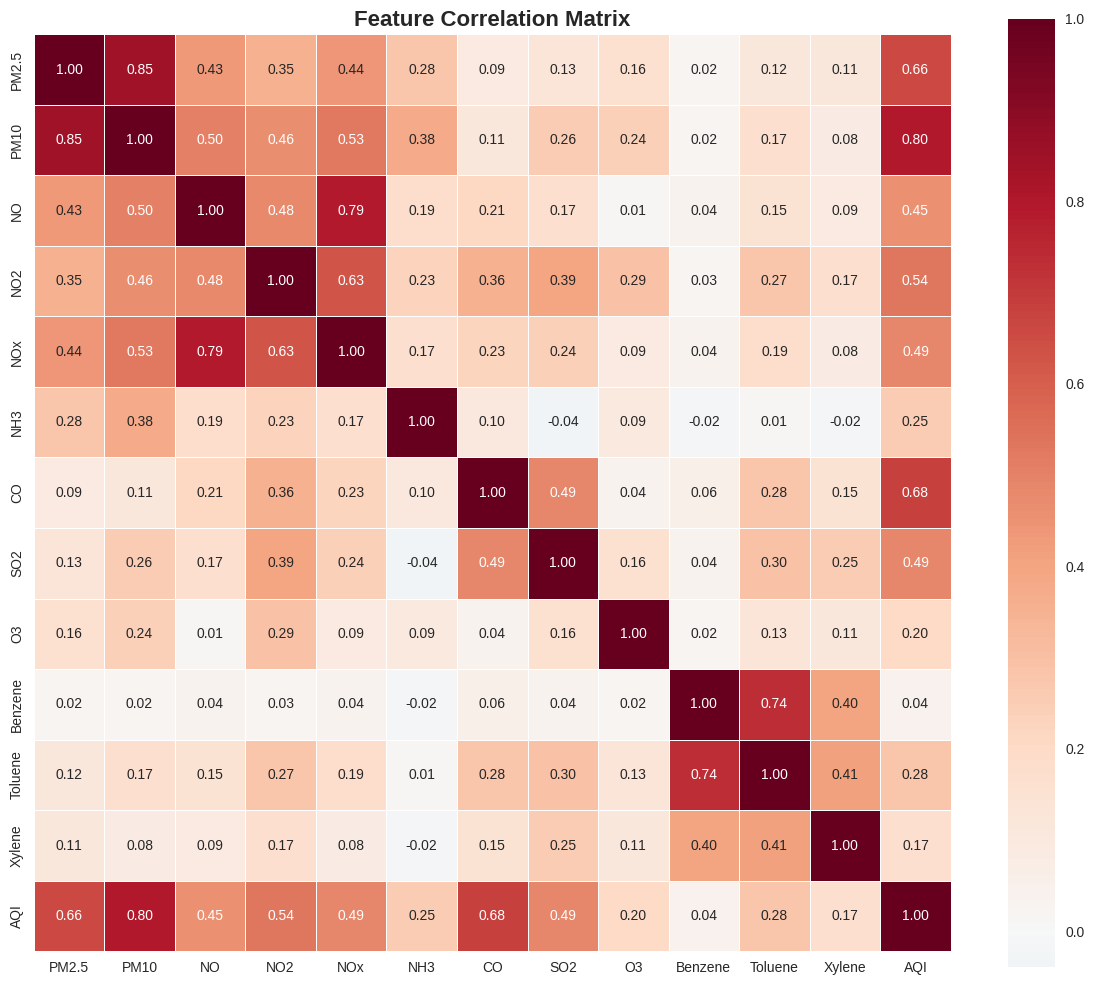


Highly correlated features (|r| > 0.7):
PM10 - PM2.5: 0.846
NOx - NO: 0.795
Toluene - Benzene: 0.739
AQI - PM10: 0.803


In [ ]:
# 3. Correlation Analysis
def plot_correlation_analysis(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if len(numerical_cols) < 2:
        print("Not enough numerical columns for correlation analysis")
        return
    corr_matrix = df[numerical_cols].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r',
                center=0, square=True, linewidths=0.5)
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    corr_matrix_abs = df[numerical_cols].corr().abs()
    upper_tri = corr_matrix_abs.where(np.triu(np.ones_like(corr_matrix_abs, dtype=bool), k=1))
    high_corr = [(column, upper_tri[column].idxmax(), upper_tri[column].max())
                 for column in upper_tri.columns if upper_tri[column].max() > 0.7]

    if high_corr:
        print("\nHighly correlated features (|r| > 0.7):")
        for col1, col2, corr in high_corr:
            print(f"{col1} - {col2}: {corr:.3f}")

plot_correlation_analysis(df)

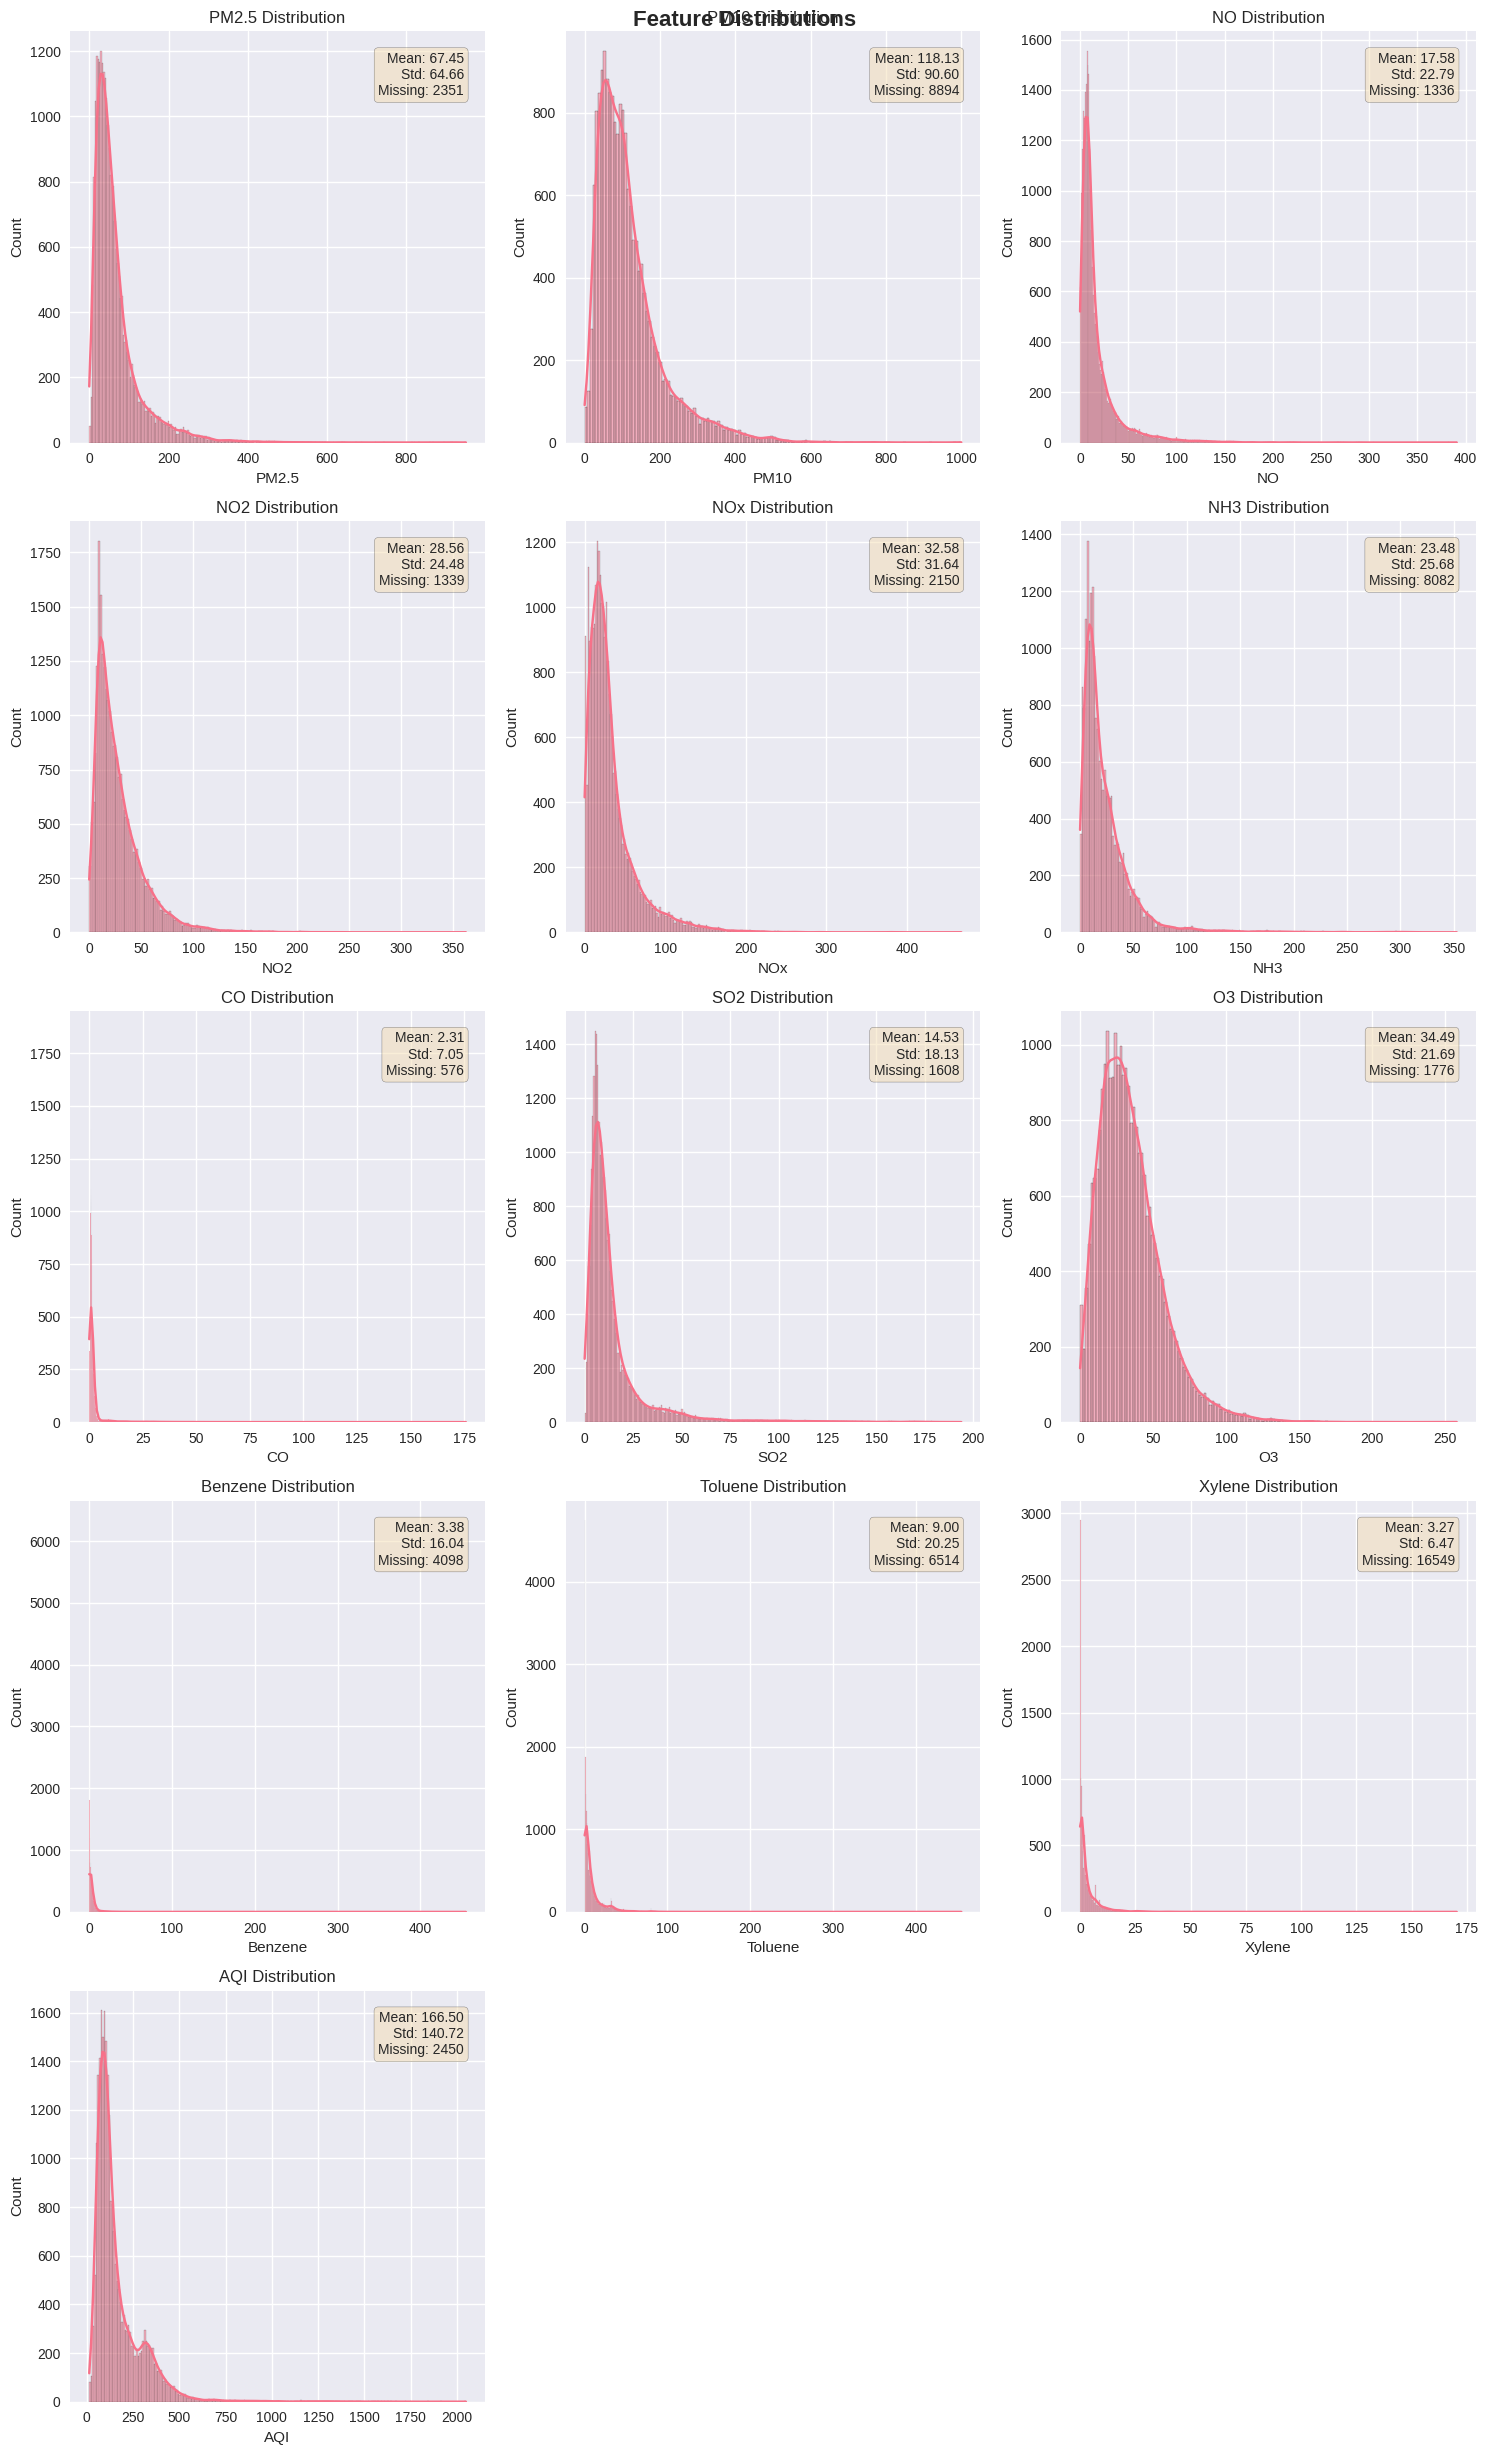

In [ ]:
# 4. Feature Distribution Analysis
def plot_feature_distributions(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if not numerical_cols:
        print("No numerical columns for distribution analysis")
        return

    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Feature Distributions', fontsize=16, fontweight='bold')
    if n_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, col in enumerate(numerical_cols):
        if i < len(axes):

            sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
            axes[i].set_title(f'{col} Distribution')
            axes[i].set_xlabel(col)
            stats_text = f'Mean: {df[col].mean():.2f}\nStd: {df[col].std():.2f}\nMissing: {df[col].isnull().sum()}'
            axes[i].text(0.95, 0.95, stats_text, transform=axes[i].transAxes,
                        verticalalignment='top', horizontalalignment='right',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_feature_distributions(df)

Creating pairplot (this may take a while for large datasets)...


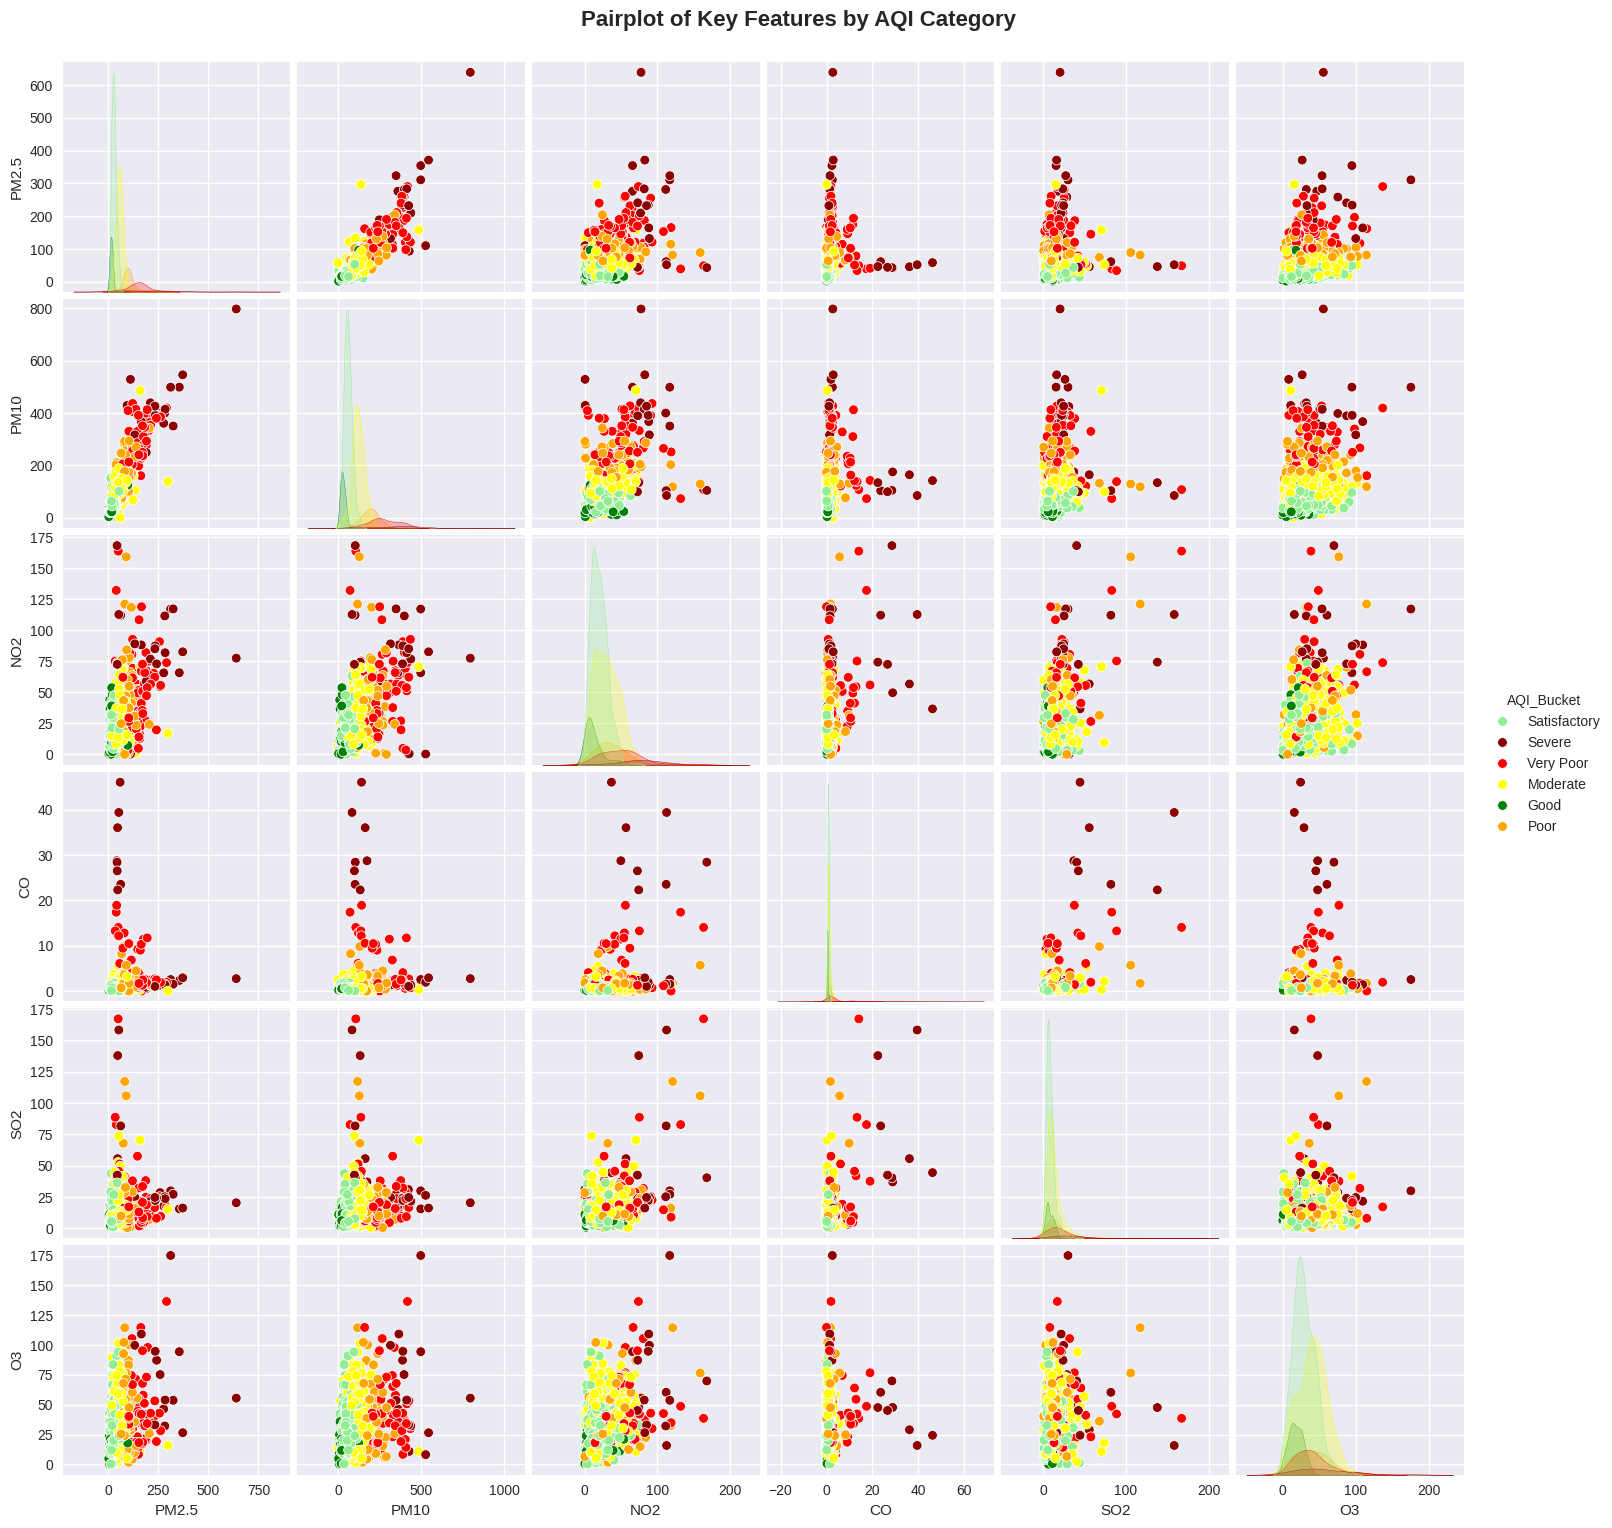

In [ ]:
# 6. Multivariate Analysis - Pairplot of key features
def plot_multivariate_analysis(df):
    key_features = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']
    key_features = [f for f in key_features if f in df.columns]

    if len(key_features) < 3:
        print("Not enough features for multivariate analysis")
        return
    if 'AQI_Bucket' in df.columns:
        sample_df = df[key_features + ['AQI_Bucket']].dropna()
        if len(sample_df) > 1000:
            sample_df = sample_df.sample(1000, random_state=42)
        g = sns.pairplot(sample_df, hue='AQI_Bucket', diag_kind='kde',
                        palette={'Good': 'green', 'Satisfactory': 'lightgreen',
                                'Moderate': 'yellow', 'Poor': 'orange',
                                'Very Poor': 'red', 'Severe': 'darkred'})
        g.fig.suptitle('Pairplot of Key Features by AQI Category', y=1.02, fontsize=16, fontweight='bold')
        plt.savefig('feature_pairplot.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        sample_df = df[key_features].dropna()
        if len(sample_df) > 1000:
            sample_df = sample_df.sample(1000, random_state=42)

        g = sns.pairplot(sample_df, diag_kind='kde')
        g.fig.suptitle('Pairplot of Key Features', y=1.02, fontsize=16, fontweight='bold')
        plt.savefig('feature_pairplot.png', dpi=300, bbox_inches='tight')
        plt.show()

plot_multivariate_analysis(df)

In [ ]:
# Preprocessing
def preprocess_data(df):
    df_processed = df.copy() #copy of df

    df_processed['AQI_Bucket'] = pd.Categorical(df_processed['AQI_Bucket'], categories=aqi_order,ordered=True)


    le = LabelEncoder()
    df_processed['AQI_Bucket_encoded'] = le.fit_transform(df_processed['AQI_Bucket'].astype(str))


    pollutant_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
                     'Benzene', 'Toluene', 'Xylene']

    df_for_analysis = df_processed.dropna(subset=['AQI_Bucket'])

    return df_processed, df_for_analysis, pollutant_cols

df_processed, df_for_analysis, pollutant_cols = preprocess_data(df)

Feature Importance for Predicting AQI_Bucket:
    Feature  Importance
1      PM10    0.274801
0     PM2.5    0.246001
6        CO    0.073995
8        O3    0.066624
4       NOx    0.055788
5       NH3    0.055605
2        NO    0.051093
3       NO2    0.045906
10  Toluene    0.035215
9   Benzene    0.034080
7       SO2    0.032120
11   Xylene    0.028772


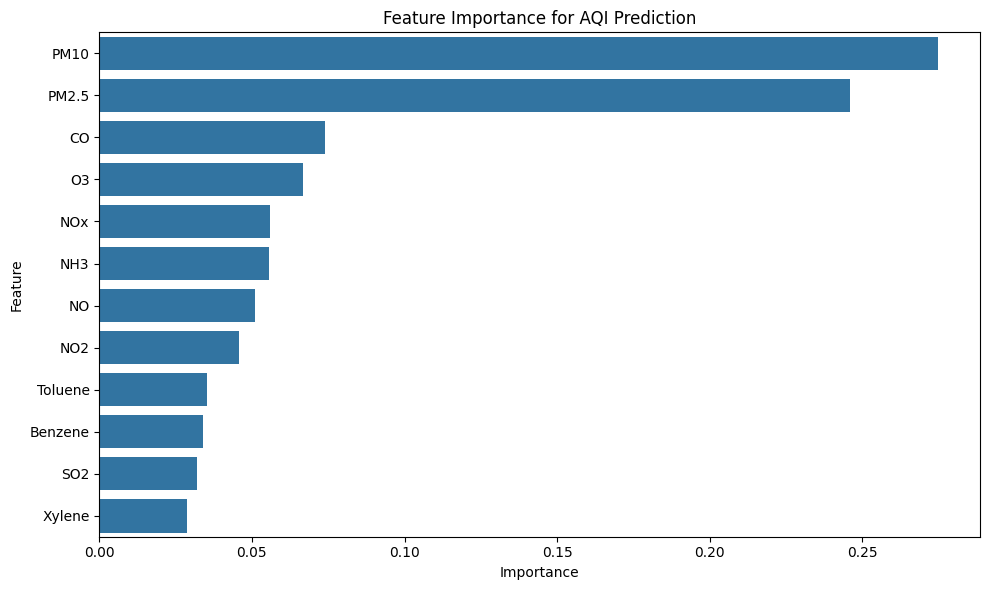

In [ ]:
def analyze_feature_importance(df, pollutant_cols):

    temp_df = df.dropna(subset=['AQI_Bucket_encoded'] + pollutant_cols, how='any')

    if len(temp_df) == 0:
        print("Not enough complete cases for feature importance analysis.")
        return None, None

    X_temp = temp_df[pollutant_cols]
    y_temp = temp_df['AQI_Bucket_encoded']


    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_temp, y_temp)

    # Get feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': pollutant_cols,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("Feature Importance for Predicting AQI_Bucket:")
    print(feature_importance_df)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importance for AQI Prediction')
    plt.tight_layout()
    plt.show()

    return rf, feature_importance_df

rf_model, feature_importance_df = analyze_feature_importance(df_for_analysis, pollutant_cols)

# **Missing Values (Imputation)**

In [ ]:
# MICE imputation
def impute_missing_values(df, pollutant_cols):
    print("Starting MICE imputation...")

    df_imputed = df.copy()

    mice_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42),max_iter=10,random_state=42,initial_strategy='mean')

    df_imputed[pollutant_cols] = mice_imputer.fit_transform(df_imputed[pollutant_cols])

    print("MICE imputation completed.")
    return df_imputed
    # Apply MICE imputation to the entire dataset
df_imputed = impute_missing_values(df_processed, pollutant_cols)

Starting MICE imputation...
MICE imputation completed.


In [ ]:
def prepare_training_data(df_imputed):
    train_df = df_imputed.dropna(subset=['AQI_Bucket'])
    X = train_df[pollutant_cols]
    y = train_df['AQI_Bucket_encoded']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

X_train, X_test, y_train, y_test, scaler = prepare_training_data(df_imputed)